In [2]:
# #hide
! [ -e /content ] && mamba install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

In [4]:
ims = search_images_ddg('gingko biloba tree leaf', max_images=10)
len(ims)

10

In [5]:
dest = 'images/tree.jpg'
download_url(ims[0], dest)

Path('images/tree.jpg')

In [ ]:
im = Image.open(dest)
im.to_thumb(128,128)

In [25]:
categories = ('ash', 'chestnut', 'ginkgo biloba', 'silver maple', 'willow oak')
path = Path('trees')

In [26]:
if not path.exists():
    path.mkdir()
    for o in categories:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} tree leaf', max_images=100)
        download_images(dest, urls=results)

In [ ]:
fns = get_image_files(path)
fns

In [10]:
failed = verify_images(fns)
failed

(#0) []

In [11]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [12]:
trees = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [13]:
dls = trees.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=12, nrows=3)

### Data Augmentation

In [ ]:
trees = trees.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = trees.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [16]:
trees = trees.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = trees.dataloaders(path)

In [17]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(5)

/Users/briansigafoos/.pyenv/versions/3.9.15/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/briansigafoos/.pyenv/versions/3.9.15/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


/Users/briansigafoos/.pyenv/versions/3.9.15/lib/python3.9/site-packages/PIL/Image.py:979: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


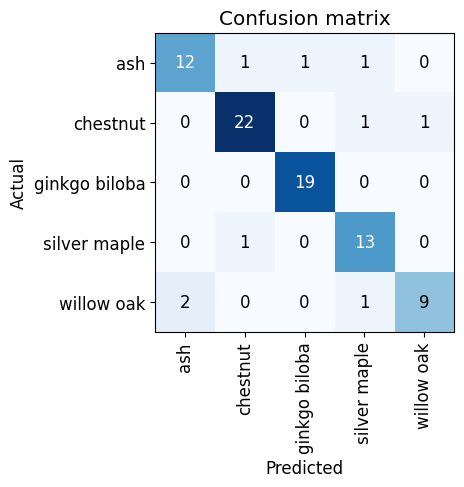

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(8, nrows=2)

In [32]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [33]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [20]:
learn.export('model.pkl')

In [21]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('model.pkl')]

In [22]:
learn_inf = load_learner(path/'model.pkl')

In [23]:
learn_inf.predict('images/ash.jpg')

('ash',
 TensorBase(0),
 TensorBase([7.8849e-01, 1.4656e-03, 4.6224e-04, 6.6382e-03, 2.0294e-01]))

In [24]:
learn_inf.dls.vocab

['ash', 'chestnut', 'ginkgo biloba', 'silver maple', 'willow oak']